In [27]:
import lasio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import glob
import os

from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import train_test_split, GridSearchCV

# model = pickle.load(open("src/model/mlp_pwr_best_model.sav", 'rb'))
scaler = pickle.load(open('/home/se760/Training/volve-machine-learning/model/scaler.sav', 'rb'))

features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target = 'DT'

In [28]:
import glob
import os

# get all paths and alphabetically ordered
paths = sorted(glob.glob(os.path.join("/home/se760/Training/volve-machine-learning/well_logs", "*.LAS")))

well_df = [0] * 5

for i in range(len(paths)):
  # read with lasio
  well = lasio.read(paths[i])

  # convert to dataframe
  df = well.df()

  # in this dataframe, depth is positioned as index, not as column
  # so better to change depth index to column
  well_df[i] = df.reset_index()

well1, well2, well3, well4, well5 = well_df

In [29]:
# lower limit
low = [2600, 3200, 2620, 3100, 3100]

# upper limit
up = [3720, 4740, 3640, 3400, 4050]

# train columns to use
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

# test columns to use
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

well_df_restrict = [0] * 5

for i in range(len(well_df)):
  # restrict depth within the given lower and upper limit
  df = well_df[i].loc[(well_df[i]['DEPTH'] >= low[i]) & (well_df[i]['DEPTH'] <= up[i])]

  if i == 0 or i == 2 or i == 3:
    # the train data, drop unwanted columns
    well_df_restrict[i] = df[train_cols]
  
  else:
    # the test data, drop unwanted columns
    well_df_restrict[i] = df[test_cols]

well1, well2, well3, well4, well5 = well_df_restrict

In [30]:
# merge dataframes
well_train = pd.concat([well1, well3, well4])
well_pred = pd.concat([well2, well5])

# assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []
for i in range(len(well_df_restrict)):
  if i == 0 or i == 2 or i == 3:
    # train data, assign names 
    _ = np.full(len(well_df_restrict[i]), names[i])
    names_train.append(_)
  else:
    # test data, assign names
    _ = np.full(len(well_df_restrict[i]), names[i])
    names_pred.append(_)

# concatenate inside list
import itertools

names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# include well names to the train and pred dataframe
well_train['WELL'] = names_train
well_pred['WELL'] = names_pred

# move the depth column to the right
depth_train, depth_pred = well_train.pop('DEPTH'), well_pred.pop('DEPTH')
well_train['DEPTH'], well_pred['DEPTH'] = depth_train, depth_pred

In [31]:
# Read normalized & processed data

well_train_norm_svm=pd.read_csv('/home/se760/Training/volve-machine-learning/output/well_train_norm_svm.csv')


In [32]:
well_train_norm_svm.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.130650,-0.631876,0.031083,0.450019,1.588380,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.758080,-0.819890,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.196481,-1.480908,0.579649,-0.636556,-1.495447,-2.108307,1.243336,15_9-F-11A,2600.6


In [33]:
# Step 6: Preliminary Prediction 

# Define the train data
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
only_target = 'DT'

X_train = well_train_norm_svm[only_feature].values
y_train = well_train_norm_svm[only_target].values

In [34]:
# Define the test data
well_train_norm=pd.read_csv('/home/se760/Training/volve-machine-learning/output/well_train_norm.csv')

well_pred_1 = well_train_norm.copy()

names_train = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_test = []
y_test = []
for i in range(len(names_train)):
  # split the df with respect to its name
  test = well_pred_1.loc[well_pred_1['WELL'] == names_train[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature) and y_test (target)
  X_test_, y_test_ = test[only_feature].values, test[only_target].values
  
  X_test.append(X_test_)
  y_test.append(y_test_)

# for each well 1, 3, and 4
X_test1, X_test3, X_test4 = X_test
y_test1, y_test3, y_test4 = y_test

In [35]:
from sklearn.metrics import mean_squared_error

# Create the regressor & train model using well_train_norm_svm
model=MLPRegressor(
        hidden_layer_sizes=(518, 256),
        alpha = 0.01,
        activation='relu',
        solver= 'adam',
        max_iter= 500,
        n_iter_no_change = 30,
        learning_rate_init = 0.05,
        verbose = True, 
        early_stopping = True)

# Fit the regressor to the training data
model.fit(X_train, y_train)

#import pickle
# model = pickle.load(open('/home/se760/Training/volve-machine-learning/model/best_model.sav', 'rb'))

# Predict on well 1
y_pred1 = model.predict(X_test1)
print("R-squared of Well 1: {}".format(model.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print("RMSE of Well 1: {}".format(rmse))

# Predict on well 3
y_pred3 = model.predict(X_test3)
print("R-squared of Well 3: {}".format(model.score(X_test3, y_test3)))
rmse = np.sqrt(mean_squared_error(y_test3, y_pred3))
print("RMSE of Well 3: {}".format(rmse))

# Predict on well 4
y_pred4 = model.predict(X_test4)
print("R-squared of Well 4: {}".format(model.score(X_test4, y_test4)))
rmse = np.sqrt(mean_squared_error(y_test4, y_pred4))
print("RMSE of Well 4: {}".format(rmse))

Iteration 1, loss = 2.53375681
Validation score: 0.925032
Iteration 2, loss = 0.16686181
Validation score: 0.947131
Iteration 3, loss = 0.13716273
Validation score: 0.934381
Iteration 4, loss = 0.11866830
Validation score: 0.945577
Iteration 5, loss = 0.10373695
Validation score: 0.946632
Iteration 6, loss = 0.09155940
Validation score: 0.954077
Iteration 7, loss = 0.08280901
Validation score: 0.946515
Iteration 8, loss = 0.07389608
Validation score: 0.954203
Iteration 9, loss = 0.06672498
Validation score: 0.953083
Iteration 10, loss = 0.06092999
Validation score: 0.955948
Iteration 11, loss = 0.05563736
Validation score: 0.957707
Iteration 12, loss = 0.05243412
Validation score: 0.955458
Iteration 13, loss = 0.04836681
Validation score: 0.956837
Iteration 14, loss = 0.04469164
Validation score: 0.957636
Iteration 15, loss = 0.04179536
Validation score: 0.957848
Iteration 16, loss = 0.03936029
Validation score: 0.956917
Iteration 17, loss = 0.03723772
Validation score: 0.955592
Iterat

In [36]:
# pickle model
pickle.dump(model, open('/home/se760/Training/volve-machine-learning/model/best_model.sav','wb'))


In [37]:
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_test1, y_pred1 = scaler.inverse_transform(y_test1.reshape(-1,1)), scaler.inverse_transform(y_pred1.reshape(-1,1))
y_test3, y_pred3 = scaler.inverse_transform(y_test3.reshape(-1,1)), scaler.inverse_transform(y_pred3.reshape(-1,1))
y_test4, y_pred4 = scaler.inverse_transform(y_test4.reshape(-1,1)), scaler.inverse_transform(y_pred4.reshape(-1,1))

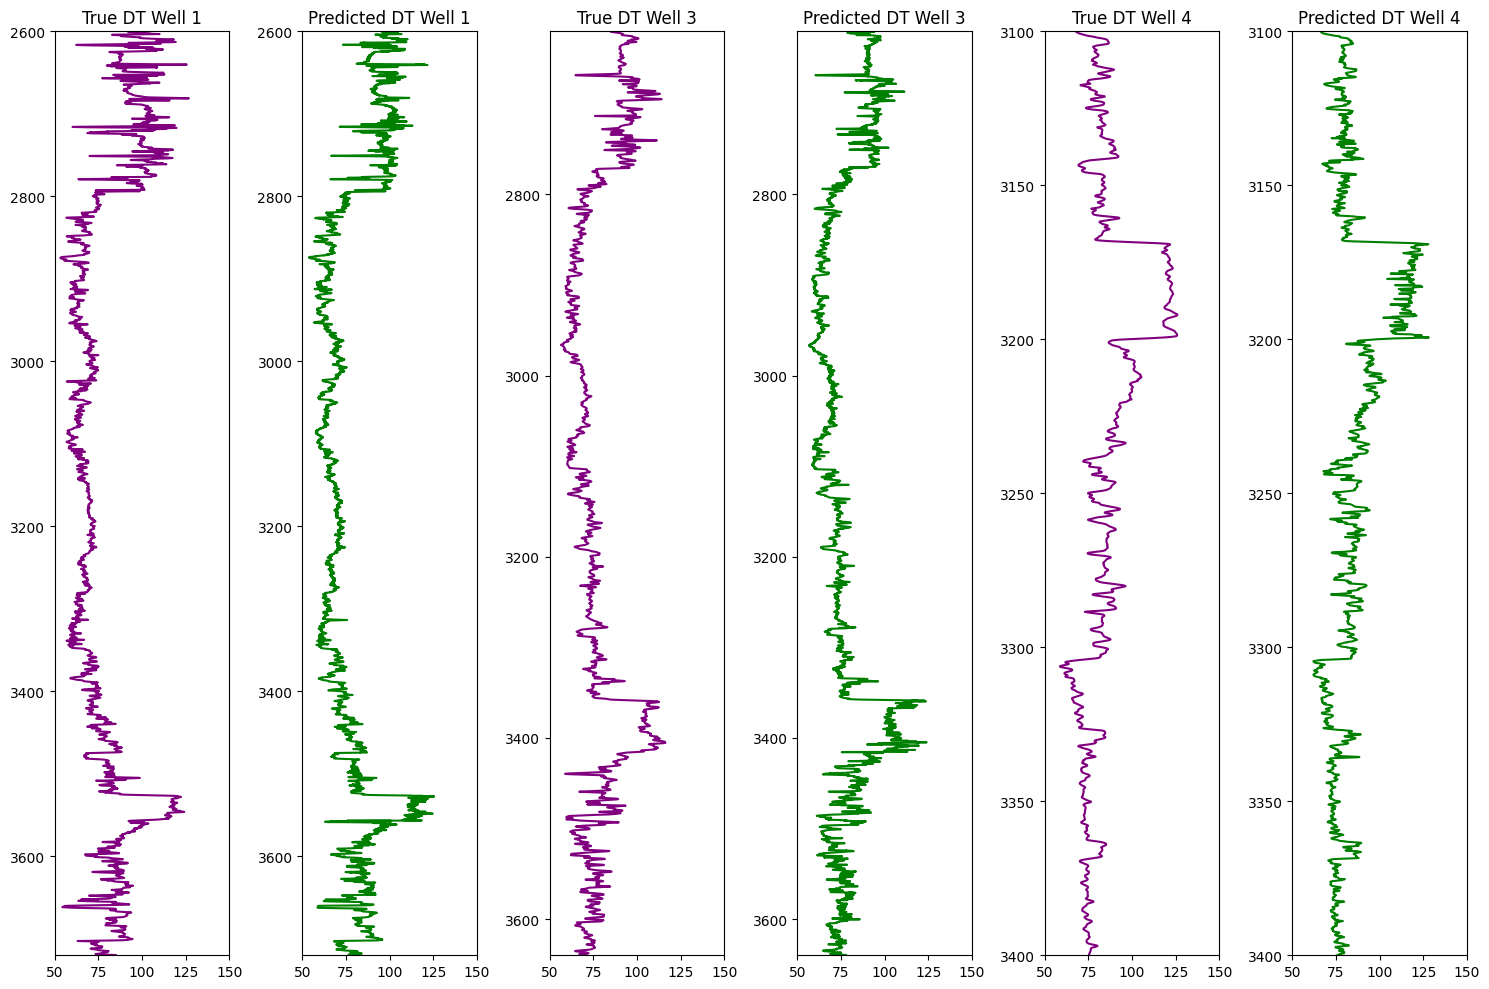

In [38]:
x = [y_test1, y_pred1, y_test3, y_pred3, y_test4, y_pred4]
y = [well1['DEPTH'], well1['DEPTH'], well3['DEPTH'], well3['DEPTH'], well4['DEPTH'], well4['DEPTH']]

color = ['purple', 'green', 'purple', 'green', 'purple', 'green']
title = ['True DT Well 1', 'Predicted DT Well 1', 'True DT Well 3', 'Predicted DT Well 3',
         'True DT Well 4', 'Predicted DT Well 4']

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,10))

for i in range(len(x)):
  ax[i].plot(x[i], y[i], color=color[i])
  ax[i].set_xlim(50, 150)
  ax[i].set_ylim(np.max(y[i]), np.min(y[i]))
  ax[i].set_title(title[i])

plt.tight_layout()

plt.show()

In [39]:
# Preprocess validation dataset & remove outlier

well_pred=pd.read_csv('/home/se760/Training/volve-machine-learning/output/well_pred.csv')

well_pred['RT'] = np.log10(well_pred['RT'])

well_pred_2 = well_pred.drop(['WELL', 'DEPTH'], axis=1)

In [40]:
# remove outliers

from sklearn.svm import OneClassSVM

# Method 5: One-class SVM
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(well_pred_2)
mask = yhat != -1
well_pred_svm = well_pred[mask]

In [41]:
colnames = well_pred.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

In [42]:
# Normalize
well, depth = well_pred_svm.pop('WELL'), well_pred_svm.pop('DEPTH')
well_pred_norm_svm = scaler.fit_transform(well_pred_svm)
well_pred_norm_svm = pd.DataFrame(well_pred_norm_svm, columns=['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI','DT'])
well_pred_svm['WELL'], well_pred_svm['DEPTH'] = well, depth

/tmp/ipykernel_11199/800583688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_pred_svm['WELL'], well_pred_svm['DEPTH'] = well, depth
/tmp/ipykernel_11199/800583688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_pred_svm['WELL'], well_pred_svm['DEPTH'] = well, depth


In [43]:
colnames = well_pred.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

Number of points before outliers removed                       : 24902
Number of points after outliers removed with One-class SVM     : 22412


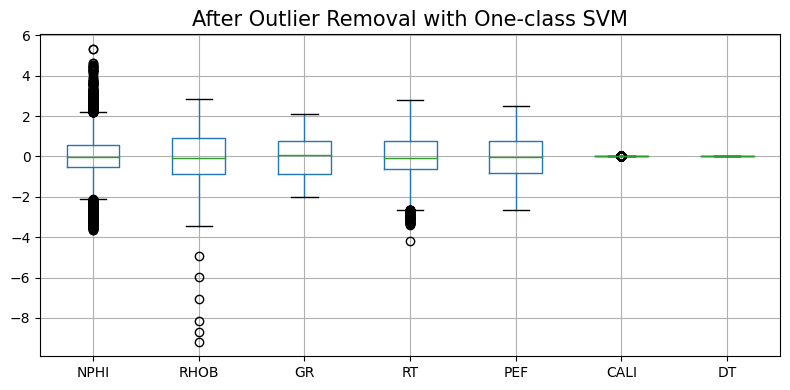

In [44]:
well_pred_norm = scaler.fit_transform(well_pred_2)

print('Number of points before outliers removed                       :', len(well_pred_norm))
print('Number of points after outliers removed with One-class SVM     :', len(well_pred_norm_svm))

plt.figure(figsize=(8,4))

well_pred_norm_svm[feature_target].boxplot()
plt.title('After Outlier Removal with One-class SVM', size=15)

plt.tight_layout()
plt.show()

In [45]:
well_pred_norm_svm.describe()

,NPHI,RHOB,GR,RT,PEF,CALI,DT
count,2.241200e+04,2.241200e+04,2.241200e+04,2.241200e+04,2.241200e+04,2.241200e+04,22412.0
mean,5.934928e-16,3.780092e-14,7.203075e-16,-3.145004e-16,-2.384116e-16,-3.945002e-18,0.0
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,2.826110e-16,0.0
min,-3.645984e+00,-9.173674e+00,-2.010218e+00,-4.176862e+00,-2.640087e+00,-1.360023e-15,0.0
25%,-4.977011e-01,-8.899862e-01,-8.736315e-01,-6.102273e-01,-8.358291e-01,-1.804112e-16,0.0
50%,-9.299047e-03,-8.333086e-02,6.165321e-02,-5.741848e-02,-1.966957e-02,5.551115e-17,0.0
75%,5.858800e-01,9.375611e-01,7.618483e-01,7.562124e-01,7.806682e-01,2.081668e-16,0.0
max,5.327358e+00,2.843604e+00,2.089990e+00,2.781286e+00,2.483050e+00,1.346145e-15,0.0


In [46]:
# Define the validation data 
# well_pred = pd.read_csv('/home/se760/Training/volve-machine-learning/output/well_pred.csv')

names_pred = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []
for i in range(len(names_pred)):
  # split the df with respect to its name
  test = well_pred_svm.loc[well_pred_svm['WELL'] == names_pred[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature)
  X_test_ = test[only_feature].values

  # define depth
  depth_ = test['DEPTH'].values
  
  X_test.append(X_test_)
  depths.append(depth_)

# for each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [47]:
# Normalize X_test of well 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

# Predict to well 2 and 5
y_pred2 = model.predict(X_test2)
y_pred5 = model.predict(X_test5)

# Denormalize y_pred of well 2 and 5
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_pred2 = scaler.inverse_transform(y_pred2.reshape(-1,1))
y_pred5 = scaler.inverse_transform(y_pred5.reshape(-1,1))

In [48]:
print(X_test5)

[[-1.15076958  1.35244152 -0.26097174 -0.24923512  1.84301795 -0.33579889]
 [-1.17255632  1.33716668 -0.29735533 -0.24705995  1.82224482 -0.33579889]
 [-1.20951454  1.32505535 -0.31345442 -0.25053853  1.80895418 -0.33579889]
 ...
 [ 0.04687803  2.22487036  0.76485331 -0.23551592  1.8921299   0.37163068]
 [ 1.18108496  2.08716396  1.64753082 -0.56391958  1.62064466  0.37163068]
 [ 1.61988374  1.94639933  2.09348563 -0.56546958  1.40775987  0.37163068]]


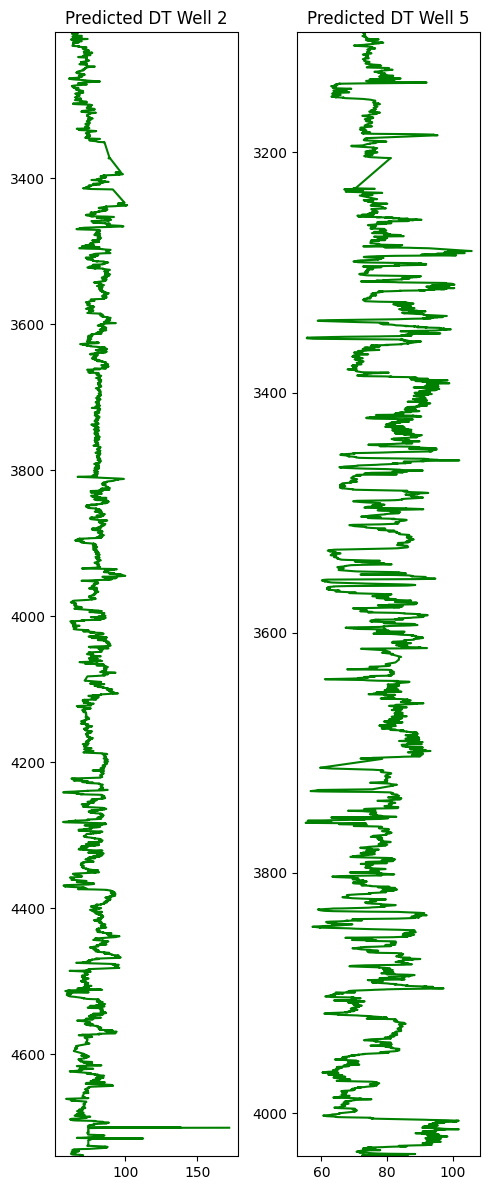

In [49]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(y_pred2, depth2, color='green')
plt.ylim(max(depth2), min(depth2))
plt.title('Predicted DT Well 2', size=12)

plt.subplot(1,2,2)
plt.plot(y_pred5, depth5, color='green')
plt.ylim(max(depth5), min(depth5))
plt.title('Predicted DT Well 5', size=12)
plt.savefig('../output/predictNN.png')
plt.tight_layout()
plt.show()


In [50]:
# NN model shows overfitting issue to outliers